# День третий - обучение без учителя*
\* и некоторые другие темы

В сегодняшнем дне нас ждут следующие темы:
1. Немного про отбор признаков и про поиск гиперпараметров,
2. Задача понижения размерности данных,
3. Кластеризация,
4. Поиск аномалий в данных,
5. Одномерные временные ряды с помощью библиотеки `Facebook Prophet`,
6. Что такое стэкинг и как предсказания моделей использовать как вход для других моделей.

## 3.1 Отбор признаков и поиск гиперпараметров

В прошлых днях мы видели, что есть хорошие и не очень хорошие признаки, которые дают прирост качеству модели, или наоборот её ухудшают. Так же мы немного наивно выставляли какие-то числа в модель - количество соседей, количество нейронов в слоях... то, что называется *гиперпараметрами модели*, при этом делали это несколько от потолка.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# загрузим наш датасет ракушек
data = pd.read_csv('data/abalone.csv')
data.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [2]:
from sklearn.utils import shuffle

# преобразуем наш категориальный признак

dataset = pd.get_dummies(data.sex).join(data).drop('sex', axis='columns')
dataset = shuffle(dataset, random_state=1)

features = list(dataset.columns)
target = 'rings'
features.remove(target)

features

['F',
 'I',
 'M',
 'length',
 'diameter',
 'height',
 'whole weight',
 'shucked weight',
 'viscera weight',
 'shell weight']

### Отбор признаков
Мы рассмотрим два метода - отбор с помощью взаимной информации между признаками, и отбор с помощью моделей. Начнем с взаимной информации. Строгого определение по сложившейся традиции тут приведено не будет, важно знать, что это *неотрицательное число*, равное 0 тогда и только когда, когда связи между признаками нет никакой. В свою очередь, чем оно больше - тем выше связь.

In [3]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest

train = int(len(data) * 0.8)

# для классификации есть mutual_info_classif

regression_best_features = SelectKBest(mutual_info_regression, k=4).fit(
    dataset[features][:train], dataset[target][:train]
).get_support(indices=True) # этот метод возращает номера колонок

print(
    "Если кольца считать как регрессию, лучшие 4 признака это", 
    np.array(features)[regression_best_features]
)

Если кольца считать как регрессию, лучшие 4 признака это ['diameter' 'height' 'whole weight' 'shell weight']


Что ж, посчитаем регрессию и классификацию на этих четырех признаках.

In [4]:
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor(random_state=1, max_iter=1000).fit(
    dataset.values[:, regression_best_features][:train],
    dataset[target][:train]
)

In [5]:
print("R2 test regression %.3f" % (
    r2_score(dataset[target][train:], regressor.predict(dataset.values[:, regression_best_features][train:]))
))

R2 test regression 0.476


Вот так можно отбирать признаки в задачах регрессии (и классификации тоже) с помощью взаимной информации. Но можно делать это еще интересней - с помощью других моделей!

> Для моделей часто важна интерпретируемость! Мы об этом будем обязательно говорить. Линейные модели и деревья - интерпретируемы, нейросети с трудом или практически нет.

**Интерпретируемость** означает, что мы можем понять, что даёт наибольший вклад в предсказания. Она может быть локальной - в одном примере, а может быть глобальной - для всей модели. Так, деревья имеют после подгонки определенные коэффициенты важности, они же `tree_estimator.feature_importances_`, которые показывают, какой признак даёт наибольший вклад в предсказание. С линейными моделями - еще проще, там коэффициенты при признаках указывают на вклад (но учитывайте единицы измерения!).

In [6]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

selector_linear = SelectFromModel(estimator=LinearRegression(normalize=True)).fit(
    dataset[features][:train], dataset[target][:train]
)

selector_forest = SelectFromModel(estimator=RandomForestRegressor(n_estimators=100, random_state=1)).fit(
    dataset[features][:train], dataset[target][:train]
)

linear_features = np.array(features)[selector_linear.get_support()]
forest_features = np.array(features)[selector_forest.get_support()]

print("По линейной модели", linear_features)
print("По случайному лесу", forest_features)

По линейной модели ['F' 'I' 'M']
По случайному лесу ['shucked weight' 'shell weight']


In [7]:
print("R2 по линейным признакам %.3f (test set)" % (
    r2_score(
        dataset[target][train:],
        MLPRegressor(random_state=1, max_iter=1000).fit(
            dataset[linear_features][:train], dataset[target][:train]
        ).predict(
            dataset[linear_features][train:]
        )
    )
))

print("R2 по признакам случайного леса %.3f (test set)" % (
    r2_score(
        dataset[target][train:],
        MLPRegressor(random_state=1, max_iter=1000).fit(
            dataset[forest_features][:train], dataset[target][:train]
        ).predict(
            dataset[forest_features][train:]
        )
    )
))

R2 по линейным признакам 0.201 (test set)


R2 по признакам случайного леса 0.537 (test set)


Как видим, линейные модели сильно проиграли случайному лесу в отборе признаков на текущих данных.

Заметим, мы использовали значения по умолчанию для `MLPRegressor`, хорошо ли это? Мы не знаем. Для того, чтобы попробовать сразу много вариантов, да еще и с кросс-валидацией, можно использовать встроенный в `scikit-learn` класс `GridSearchCV`, который осуществляет *перебор по сетке гиперпараметров*.

Можно показать как это работает на примере.

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# перебор всех сочетаний параметров
# это может занимать много времени!

search = GridSearchCV(
    KNeighborsRegressor(),
    param_grid = {
        'n_neighbors': [3, 5, 7, 10, 25],
        'weights': ['uniform', 'distance']
    },
    cv=5
).fit(
    dataset[features], dataset[target]
)

'лучший отобранный по кросс-валидации', search.best_estimator_, \
'наилучшее значение метрики (R2) %.3f' % search.best_score_

('лучший отобранный по кросс-валидации',
 KNeighborsRegressor(n_neighbors=25, weights='distance'),
 'наилучшее значение метрики (R2) 0.540')

Как видим, ближайшие соседи могут даже сравниться с нейросетями.

> Имейте в виду! Когда мы отобрали по кросс-валидации лучшие гиперпараметры, перед отправкой модели в *среду эксплуатации* (для работы сайта например), мы можем её обучить с найденными параметрами уже на всех данных. Хуже от этого она предсказывать не будет - если вы, конечно, почистили данные от выбросов.


### В качестве заключения
Не стоит в любом случае сильно увлекаться автоматическими отборами и переборами - разведочный анализ пропускать нельзя. Но если признаков не 5 и не 10, эти методы могут сослужить хорошую службу. Их даже можно объединять в так называемые `pipelines`, то есть соединять последовательно (и далее мы это будем делать). 

## 3.2 Понижение размерности

Задача понижения размерности - это задача обучения без учителя, то есть когда у нас **нет правильных ответов**. Решение задач без разметки ответов часто используется для анализа и предобработки, например для отображения сложных данных.

Понижение размерности - это сжатие признаков датасета до меньшего числа (размерности), при попытке не потерять информацию в них и их полезные свойства. 

### Principal component analysis (PCA)

`PCA` - это линейное преобразование (то есть $y_j = \sum k_{ij} x_i + b_j$) всех признаков данных, с целью оставить в них как больше информации - а точнее, оставить как можно больше разброса в величинах. Главная компонента - это направление в данных, в котором разброс (вариабельность) этих самых данных наибольшая (и далее берется следующее направление). Направлений столько, сколько признаков в данных.

> **ВАЖНО**: поскольку `PCA` работает с разбросом, все величины надо стандартизировать (вычесть среднее и разделить на разброс), чтобы привести к единой шкале!

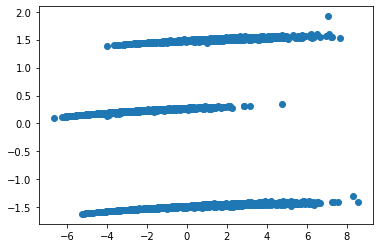

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

# отобразим все признаки кроме колец на плоскость
PCA = make_pipeline(
    StandardScaler(), PCA(n_components=2)
)

transformed = PCA.fit_transform(dataset[features])

plt.scatter(transformed[:, 0], transformed[:, 1]);

Вот как-то так. Являются ли полученные полосы разделением по полам?

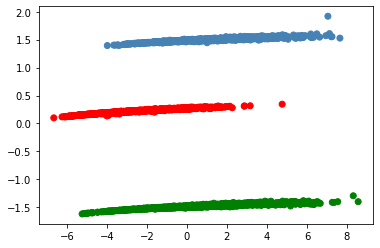

In [10]:
colors = []

for sample in dataset.values:
    if sample[0] == 1:
        colors.append('steelblue')
    elif sample[1] == 1:
        colors.append('red')
    else:
        colors.append('green')

plt.scatter(transformed[:, 0], transformed[:, 1], c=colors);

Какой из этого можно сделать вывод? Что данные хорошо разделяются по полам? Нет, не такой вывод, но то, что пол - это одно из важнейших различий в данных. И, возможно, имеет смысл делать три модели для каждого пола.

Существует достаточно сложный метод `UMAP`, который укладывает на плоскость все данные (может и в более высокие размерности, но не более размерности данных). Не так сейчас важно как он работает в теории (в теории он ищет меньший граф связей, похожий на полученный из данных, активно при этом эксплуатируя важность ближайших для каждой точки данных), сколько важно посмотреть как он отработает на наших данных.

Суть в том, что он делает это нелинейно.

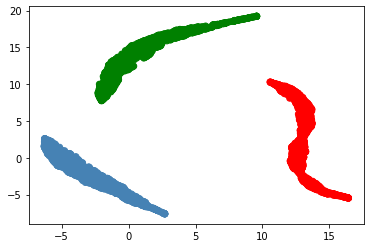

In [11]:
# запретим предупреждения
import warnings
warnings.filterwarnings('ignore')

from umap import UMAP

# поступим аналогично

transformed = make_pipeline(
    StandardScaler(), UMAP()
).fit_transform(dataset[features])
plt.scatter(transformed[:, 0], transformed[:, 1], c=colors);

Это, конечно, замечательно, но интересует, разделяются ли данные по полам, если эти признаки пола убрать?

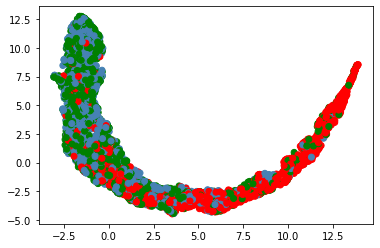

In [12]:
transformed = make_pipeline(
    StandardScaler(), UMAP()
).fit_transform(dataset[features[3:]])
plt.scatter(transformed[:, 0], transformed[:, 1], c=colors);

Как видим, не очень хорошо, и пол - это очень важный признак. Если бы мы хотели по остальным признакам различать пол, у нас бы это плохо получалось.

Для текстов тоже можно решать задачу понижения размерности, и можно с помощью *Латентного размещения Дирихле (LDA, Latent Dirichlet Allocation)*. Это позволит выделять тематическую направленность в текстах: тема будет состоять из самых общеупотребимых слов.

Давайте загрузим наш датасет `20 newsgroups`.

In [13]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

data_all = fetch_20newsgroups(subset='all', random_state=1, remove=('headers'))

from stop_words import get_stop_words
stop_words = get_stop_words('en')

def clear_stops(text):
    result = []
    for word in text.lower().split():
        stripped = word.strip()
        if stripped in stop_words:
            continue
        if sum(map(lambda symbol: symbol.isdigit(), stripped)):
            continue
        result.append(stemmer.stem(stripped))
    return ' '.join(result)

texts_all = [
    clear_stops(text) for text in data_all.data
]

text_vectorizer = CountVectorizer(
    min_df=0.01,
    max_df=0.05
).fit(texts_all)

vectors_all = text_vectorizer.transform(texts_all)

vectors_all.shape

Пусть мы хотим выделить 7 тем, и каждую охарактеризуем 10 словами.

In [14]:
%%time

from sklearn.decomposition import LatentDirichletAllocation as LDA

# это занимает некоторое время!
lda = LDA(n_components=7, random_state=1).fit(vectors_all)

Wall time: 1min 12s


In [15]:
print("Найденные темы")

# LDA требует нормировки своих компонент, тогда они "покажут" распределение слов
normed = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
topics = []

for component in normed:
    topic = np.array(text_vectorizer.get_feature_names())[[
      feature for feature in component.argsort()
    ]].tolist()[::-1][:10]
    print(str(topic))
    topics += [topic]

Найденные темы
['fire', 'bike', 'children', 'fbi', 'love', '__', 'hell', '___', 'dod', 'koresh']
['key', 'space', 'encrypt', 'chip', 'nasa', 'secur', 'clipper', 'orbit', 'launch', 'develop']
['card', 'disk', 'dos', 'driver', 'mac', 'speed', 'scsi', 'board', 'pc', 'monitor']
['israel', 'war', 'american', 'mr', 'jew', 'turkish', 'isra', 'muslim', 'arab', 'presid']
['team', 'jesus', 'player', 'win', 'hockey', 'season', 'christ', 'hit', 'fan', 'church']
['gun', 'human', 'moral', 'argument', 'evid', 'object', 'accept', 'truth', 'natur', 'agre']
['imag', 'version', 'ftp', 'display', 'server', 'user', 'code', 'format', 'color', 'applic']


И предскажем тему для первого текста. **Кстати, как работает LDA**? Ответ: сложно. Коротенько если - то по Байесу. Чуть подробнее если, то формулируется приор на размещение слов по темам (по распределению Дирихле), аналогично - по распределению документов по темам. Далее идёт максимизация вероятности отнесения слова к теме по параметрам этих распределений. 

In [16]:
examples = 1

print([text[200:400] for text in texts_all[:examples]])
print()

# transform - возвращает (ненормированное) распределение уже топиков (а не слов)
predicted_components = lda.transform(text_vectorizer.transform(texts_all[:examples]))    
predicted_components = np.array(predicted_components)

# нормируем
normed_args = predicted_components / predicted_components.sum(axis=1)[:, np.newaxis]

print(str(np.array(topics)[
    normed_args.argmax(axis=1) # здесь по нашим 7 темам выбираем наибольшее значение
].tolist()))    

['cogn one day seven holy. >jesus also recogn holi days, like passover. act say >that lay gentil necessary. >the sabbath list, epistl instruct peopl >to keep day, christian live among peopl >keep day. l']

[['team', 'jesus', 'player', 'win', 'hockey', 'season', 'christ', 'hit', 'fan', 'church']]


### Заключение
Методы понижения размерности могут и в основном используются для двух целей:
1. Цели визуализации сложных данных,
2. Цели сокращения размерности задачи, то есть уменьшения количества входных признаков.

**Учтите!** Когда вы используете методы понижения размерности и собираетесь результат передавать в модель, *делайте для них **подгонку только на тренировочном** множестве*!

## 3.3 Кластеризация

Кластеризация - задача обучения без учителя, в которой каждому примеру надо сопоставить номер группы (кластера) таким образом, чтобы схожие примеры были в одном кластере. Что значит схожие? Это означает близкие по некоторому расстоянию.

Расстояние:
- может быть евклидовым: $d(a, b) = \sqrt {\sum (a_i - b_i)^2}$,
- косинусным: `d(a, b) = 1 - косинус угла между векторами (a, b) =` $1 - \frac { \sum a_i b_i } {\sqrt {\sum a_i ^2} \sqrt { \sum b_i^2}}$,
- манхэттэнским (по координатным прямым между точками): $d(a, b) = \sum |a_i - b_i|$,
- есть и другие расстояния.

Но как можно найти кластеры в данных? Давайте рассмотрим алгоритм, который разбивает точки на заранее заданное число кластеров.
1. На первом шаге мы инициализируем случайные центроиды кластеров (случайные точки),
2. Посчитаем расстояния между каждой точкой и центроидами,
3. Присвоим номера кластеров точкам по ближайшему расстоянию до конкретного центроида,
4. Пересчитаем центроиды как центры полученных кластеров,
5. Повторим шаги 2-4, пока центроиды не перестанут меняться.

In [17]:
from sklearn.datasets import load_iris

# заберем только признаки, и только последние два, перемешаем
X = shuffle(load_iris(return_X_y=True)[0][:, -2:], random_state=1)

def distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

def clustering(number_clusters, X):
    np.random.seed(1)
    
    # шаг 1 - случайная инициализация
    centroids = np.array([
        [
            np.random.uniform(X[:, 0].min(), X[:, 0].max()),
            np.random.uniform(X[:, 1].min(), X[:, 1].max())
        ] for _ in range(number_clusters)
    ]).reshape(number_clusters, 2)
    
    previous = np.zeros_like(centroids)
    clusters = None
    
    iteration = 0
    while not np.allclose(previous, centroids):
        previous = centroids.copy()
    
        # шаг 2, считаем все расстояния
        distances = []
        for centroid in centroids:
            distances.append([
                distance(X[index], centroid) \
                for index in range(len(X))
            ])
        
        distances = np.array(distances).reshape(
            number_clusters, len(X)
        )
        
        # шаг 3, присваеваем метки точкам
        clusters = []
        for index in range(len(X)):
            clusters.append(
                np.argmin(distances[:, index])
            )
        clusters = np.array(clusters).reshape(len(X))
        
        # шаг 4, пересчитываем центроиды
        centroids = []
        for index in range(number_clusters):
            centroids.append([
                X[np.where(clusters == index), 0].mean(),
                X[np.where(clusters == index), 1].mean(),
            ])
        centroids = np.array(centroids).reshape(number_clusters, 2)
        
        iteration += 1
        print("%d, изменение расстояния центроидов %.4f" % (
            iteration, distance(previous, centroids)
        ))
    
    return centroids, clusters
            
centroids, clusters = clustering(3, X)

1, изменение расстояния центроидов 1.6271
2, изменение расстояния центроидов 0.1064
3, изменение расстояния центроидов 0.1023
4, изменение расстояния центроидов 0.0460
5, изменение расстояния центроидов 0.0828
6, изменение расстояния центроидов 0.1951
7, изменение расстояния центроидов 0.2680
8, изменение расстояния центроидов 0.8304
9, изменение расстояния центроидов 0.7299
10, изменение расстояния центроидов 0.3966
11, изменение расстояния центроидов 0.2829
12, изменение расстояния центроидов 0.1459
13, изменение расстояния центроидов 0.0431
14, изменение расстояния центроидов 0.0648
15, изменение расстояния центроидов 0.0220
16, изменение расстояния центроидов 0.0000


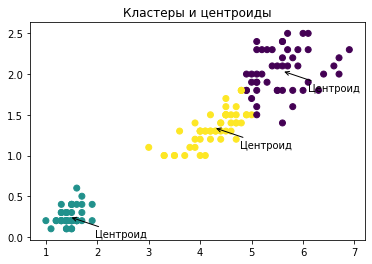

In [18]:
plt.title("Кластеры и центроиды");
plt.scatter(X[:, 0], X[:, 1], c=clusters);
for index, centroid in enumerate(centroids):
    plt.annotate(
        "Центроид",
        (centroid[0], centroid[1]),
        (centroid[0] + 0.5, centroid[1] - 0.25),
        arrowprops={"arrowstyle": '->'}
    );

Всё то же самое, только лучше, умеет делать класс `KMeans` из библиотеки `scikit-learn`. Посмотрим как он работает, но сперва узнаем, что для кластеризации тоже существуют метрики качества, и одна из самых интересных - это *метрика силуэта*, `silhouette_score`.

Метрика силуэта меняется от -1 (худший случай) до +1 (лучший), и показывает, насколько "хорошо" принадлежат точка своему кластеру (для всех данных - значение усредняется). Хорошо принадлежит, это значит расстояние до ближайшего кластера, отличного от кластера точки, больше расстояния до кластера самой точки. Или, еще проще, точка находится среди таких же.

Поэтому в случае, когда мы не знаем количество кластеров заранее, мы можем перебирать и сравнивать их по метрике силуэта.

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_score = -1
best_number = 0

whole_X = shuffle(
    load_iris(return_X_y=True)[0],
    random_state=1
)

# переберем от 22 кластеров до 2
for number_clusters in range(22, 1, -1):
    clusterer = KMeans(n_clusters=number_clusters, random_state=1).fit(whole_X)
    score = silhouette_score(whole_X, clusterer.labels_)
    
    if score > best_score:
        best_score = score
        best_number = number_clusters
        print("%d: улучшение, метрика силуэта %.3f" % (number_clusters, score))

22: улучшение, метрика силуэта 0.278
18: улучшение, метрика силуэта 0.289
15: улучшение, метрика силуэта 0.295
14: улучшение, метрика силуэта 0.309
11: улучшение, метрика силуэта 0.317
10: улучшение, метрика силуэта 0.325
9: улучшение, метрика силуэта 0.341
8: улучшение, метрика силуэта 0.350
7: улучшение, метрика силуэта 0.359
6: улучшение, метрика силуэта 0.365
5: улучшение, метрика силуэта 0.489
4: улучшение, метрика силуэта 0.498
3: улучшение, метрика силуэта 0.553
2: улучшение, метрика силуэта 0.681


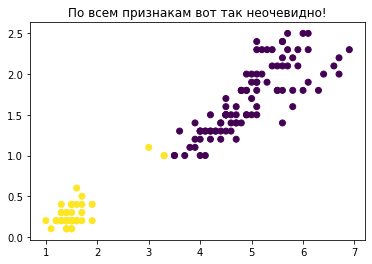

In [20]:
plt.title("По всем признакам вот так неочевидно!");
clusterer = KMeans(n_clusters=best_number, random_state=1).fit(whole_X)
plt.scatter(X[:, 0], X[:, 1], c=clusterer.labels_);

Внезапно оказалось, что два кластера - это лучшее разбиение точек на группы с точки зрения метрики силуэта! То есть делить цветы на три сорта не факт что правильно, так как две группы очень схожи.

Есть методы, которые заранее не требуют задавать количество кластеров, и мы такой рассмотрим, он называется `DBSCAN`. Он, в свою очередь, требует как минимум задать размер шара, попадая в который соседние для выбранной точки считаются попадающими в одну группу.

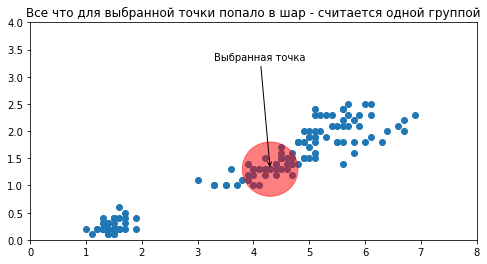

In [21]:
plt.figure(figsize=(8, 4));

plt.title("Все что для выбранной точки попало в шар - считается одной группой");
plt.gcf().gca().add_artist(plt.Circle(X[len(X) // 2], 0.5, color='red', alpha=0.5));
plt.scatter(X[:, 0], X[:, 1]);

plt.annotate(
    "Выбранная точка",
    X[len(X) // 2],
    (X[len(X) // 2, 0] - 1, X[len(X) // 2, 1] + 2),
    arrowprops={"arrowstyle": '->'}
)

plt.xlim(0, 8);
plt.ylim(0, 4);

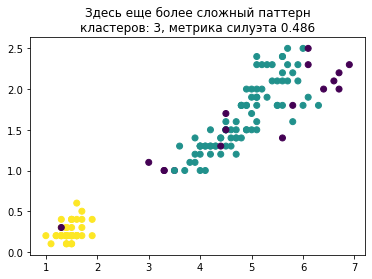

In [22]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5).fit(whole_X)
plt.title("Здесь еще более сложный паттерн\nкластеров: %d, метрика силуэта %.3f" % (
    len(pd.unique(dbscan.labels_)), silhouette_score(whole_X, dbscan.labels_)
));
plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels_);

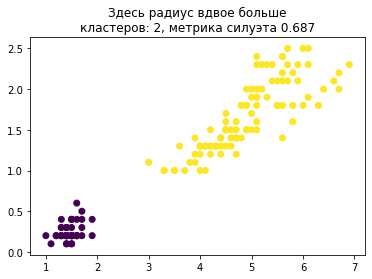

In [23]:
dbscan = DBSCAN(eps=1).fit(whole_X)
plt.title("Здесь радиус вдвое больше\nкластеров: %d, метрика силуэта %.3f" % (
    len(pd.unique(dbscan.labels_)), silhouette_score(whole_X, dbscan.labels_)
));
plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels_);

### В качестве заключения

Что может кластеризация? **Разбить на группы? Не только это**. После разбиения на группы с помощью анализа признаков можно добиться очень содержательных выводов. Так, рассмотрев более пристально что попадает в каждую группу (какие значения признаков), можно узнать о процессе гораздо больше, чем просто глядя на сырые данные. И получить ответы на поставленные вопросы.

## 3.4 Поиск аномалий в данных

Поиск аномалий - тоже задача обучения без учителя, то есть что именно является аномалией - неизвестно, разметки нет. Однако аномалии - это данные, которые сильно отличаются от остальных, и это достаточно частая задача в аналитике.

Например, поиск странных финансовых транзакций в банках. Мы же для примера поищем "аномальные ракушки". И первое что мы попробуем - это искать их с помощью деревьев.

Алгоритм `IsolationForest` использует множество деревьев, каждое из которых по выбранному признаку (с помощью случайных разбиений данных при обучении) выдает решение - является пример аномалией (*outlier*) или нет (*inlier*).

In [24]:
# считаем наши данные и выберем пару колонок сразу
data = pd.read_csv('data/abalone.csv')[
    ['length', 'height']
]

from sklearn.ensemble import IsolationForest
isolation = IsolationForest(
    n_estimators=100, # количество деревьев
    contamination=0.1, # предварительный процент аномалий
)

isolation.fit(data)

IsolationForest(contamination=0.1)

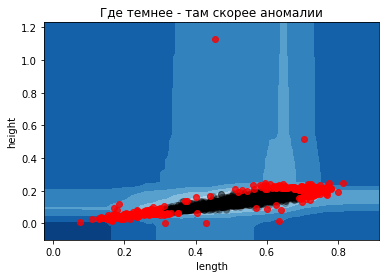

In [25]:
def plot_boundaries_IF(estimator, data, draw_columns):
    xx, yy = np.meshgrid(
        np.linspace(data[draw_columns[0]].min() - 0.1, data[draw_columns[0]].max() + 0.1),
        np.linspace(data[draw_columns[1]].min() - 0.1, data[draw_columns[1]].max() + 0.1)
    )
    Z = estimator.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.title("Где темнее - там скорее аномалии")
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    
    predictions = estimator.predict(data)
    outliers = predictions < 0
    inliers = predictions > 0
    
    plt.scatter(
        data[draw_columns[0]].values[inliers],
        data[draw_columns[1]].values[inliers],
        c='black', alpha=0.2
    );
    
    plt.scatter(
        data[draw_columns[0]].values[outliers],
        data[draw_columns[1]].values[outliers],
        c='red', alpha=0.8
    );
    
    plt.xlabel(draw_columns[0]);
    plt.ylabel(draw_columns[1]);
    
plot_boundaries_IF(isolation, data, ['length', 'height']);

Как мы знаем, деревья действуют по осям, разбивая данные на части больше-меньше порога. Чем больше деревьев - тем сглаженней картина. Сейчас же мы посмотрим как работает метод `Local Outlier Factor` (*LOF*).

Он в каждой точке оценивает плотность относительно других точек (с помощью близости). Чем ниже эта плотность - тем аномальнее пример. Он позволяет (`novelty = True`) оценивать, из того же распределения новые данные (*inlier*) или нет (*outlier*), при этом считается что тренировочные данные - без выбросов!

> Следовательно, **LOF с novelty=True нужно применять только к новым данным, *не к тренировочным*** (тем более что метод базируется на ближайших соседях). Тогда он будет определять выбросы в новых данных.

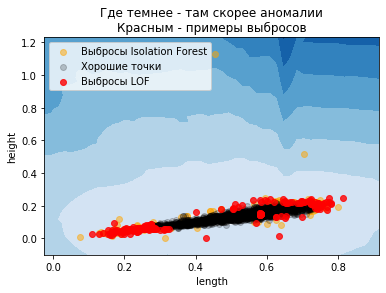

In [26]:
from sklearn.neighbors import LocalOutlierFactor

train = len(data) // 2 # половину как тренировочные данные

indices = shuffle(list(range(len(data))), random_state=1)
train_indices, test_indices = indices[:train], indices[train:]

isolator = IsolationForest(
    100, contamination=0.1
).fit(data.iloc[train_indices])

predicted = isolator.predict(data.iloc[train_indices])
outliers = predicted < 0
inliers = predicted > 0

lof = LocalOutlierFactor(
    n_neighbors=10,
    contamination=0.01, # в десять раз меньше
    novelty=True
).fit(data.iloc[train_indices].values[inliers])

# отрисуем границу принятия решений

xx, yy = np.meshgrid(
    np.linspace(data['length'].min() - 0.1, data['length'].max() + 0.1),
    np.linspace(data['height'].min() - 0.1, data['height'].max() + 0.1)
)
Z = lof.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Где темнее - там скорее аномалии\nКрасным - примеры выбросов")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

plt.scatter(
    data.iloc[train_indices]['length'].values[outliers],
    data.iloc[train_indices]['height'].values[outliers],
    c='orange', alpha=0.5, label="Выбросы Isolation Forest"
);

predicted = lof.predict(data.iloc[test_indices])
outliers = predicted < 0
inliers = predicted > 0

plt.scatter(
    data.iloc[test_indices]['length'].values[inliers],
    data.iloc[test_indices]['height'].values[inliers],
    c='black', alpha=0.2, label="Хорошие точки"
);

plt.scatter(
    data.iloc[test_indices]['length'].values[outliers],
    data.iloc[test_indices]['height'].values[outliers],
    c='red', alpha=0.8, label="Выбросы LOF"
);

plt.xlabel('length');
plt.ylabel('height');

plt.legend(loc='upper left');

### Заключение

Анализ аномалий - это не просто найти аномальные точки. Следует исследовать, чем всё же эти точки аномальны.

Можно ли использовать анализ аномалий для чистки данных? Всё что не запрещено - то разрешено. Только учтите, что вы должны продумать что делать, если новая точка при предсказании - аномальна.

## 3.5 Одномерные временные ряды

Временные ряды - это последовательные данные, в которых **порядок важен**. Перемешивать их вредно. Рассмотрим датасет *airpassengers* (авиапассажиров), который мы уже рассматривали ранее.

Это одномерный временной ряд - это значит у нас есть только одна последовательность (один признак).

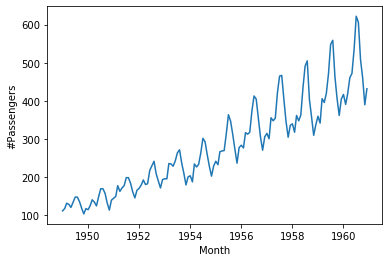

In [27]:
airpassengers = pd.read_csv('data/airpassengers.csv', parse_dates=['Month'])
sns.lineplot(x="Month", y="#Passengers", data=airpassengers);

Одномерные временные ряды можно декомпозировать на 
- тренд (направление),
- сезонности (повторяющиеся компоненты),
- праздники (пики в праздничные дни),
- добавлять регрессоры (ряды перестают быть одномерными :)).

**Основное правило с одномерными рядами такое** - если вы можете продолжить его визуально, то скорее всего сможете и с помощью машинного обучения. Иначе практически бесполезно.

Рассмотрим модель `Prophet` из библиотеки `fbprophet`. Она поступает с временным рядом именно так, как выше, то есть декомпозирует его на тренд и на одну и более сезонности (если надо, можно учитывать праздники). Еще в неё можно передавать влияющие переменные (регрессоры), но мы не будем.

`y(time) = trend(time) + seasonality(time) + holidays(time) [ + regressors(time)]`.

In [28]:
import fbprophet

model = fbprophet.Prophet(
    daily_seasonality=False, # без внутридневной сезонности
    weekly_seasonality=False, # и без недельной
    yearly_seasonality=7 # количество "изгибов" в сезонности
)

train = int(len(airpassengers) * 0.8) # длина тренировочных данных

# для fbprophet необходимо передавать колонки с заданными именами

traininig_data = airpassengers.rename({
    'Month': 'ds',
    '#Passengers': 'y'
}, axis='columns')[:train]

model.fit(traininig_data)

future = model.make_future_dataframe(
    12 + len(airpassengers) - train, # сколько точек наперёд
    freq='MS' # шагаем по началу месяца (Month Start)
)

forecast = model.predict(future)
forecast[[
    'ds', 'trend', 'yhat'
]].tail()

,ds,trend,yhat
151,1961-08-01,512.574289,562.072396
152,1961-09-01,515.728581,529.287096
153,1961-10-01,518.781121,499.154882
154,1961-11-01,521.935412,473.169651
155,1961-12-01,524.987953,499.495222


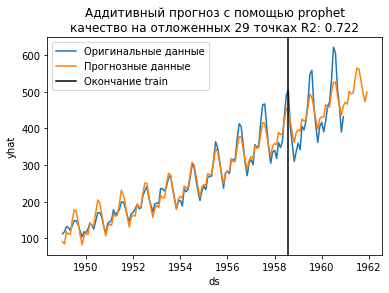

In [29]:
plt.title("Аддитивный прогноз с помощью prophet\nкачество на отложенных %d точках R2: %.3f" % (
    len(airpassengers) - train, r2_score(
        y_true=airpassengers['#Passengers'].values[train:],
        y_pred=forecast.yhat.values[train:len(airpassengers)]
    )
))
sns.lineplot(x="Month", y="#Passengers", data=airpassengers, label="Оригинальные данные");
sns.lineplot(x="ds", y="yhat", data=forecast, label="Прогнозные данные");
plt.axvline(airpassengers.Month[train], 0, 1, c='black', label='Окончание train');
plt.legend(loc='best');

Как видим, получилось не очень хорошо. Аддитивная модель - это когда компоненты складываются - не уловила в данных той сути, что сезонность увеличивается. Заменим её на мультипликативную - одним параметром.

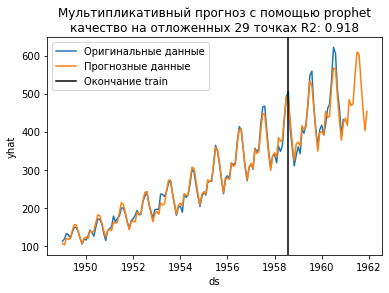

In [30]:
model = fbprophet.Prophet(
    daily_seasonality=False, # без внутридневной сезонности
    weekly_seasonality=False, # и без недельной
    yearly_seasonality=7, # количество "изгибов" в сезонности
    seasonality_mode='multiplicative'
)

train = int(len(airpassengers) * 0.8) # длина тренировочных данных

# для fbprophet необходимо передавать колонки с заданными именами

traininig_data = airpassengers.rename({
    'Month': 'ds',
    '#Passengers': 'y'
}, axis='columns')[:train]

model.fit(traininig_data)

future = model.make_future_dataframe(
    12 + len(airpassengers) - train, # сколько точек наперёд
    freq='MS' # шагаем по началу месяца (Month Start)
)

forecast = model.predict(future)

plt.title("Мультипликативный прогноз с помощью prophet\nкачество на отложенных %d точках R2: %.3f" % (
    len(airpassengers) - train, r2_score(
        y_true=airpassengers['#Passengers'].values[train:],
        y_pred=forecast.yhat.values[train:len(airpassengers)]
    )
))
sns.lineplot(x="Month", y="#Passengers", data=airpassengers, label="Оригинальные данные");
sns.lineplot(x="ds", y="yhat", data=forecast, label="Прогнозные данные");
plt.axvline(airpassengers.Month[train], 0, 1, c='black', label='Окончание train');
plt.legend(loc='best');

Почему модель с умножением получилась лучше? Потому что чтобы сделать аддитивную модель мультипликативной, достаточно преобразовать целевую величину, например через логарифмирование. Посмотрим.

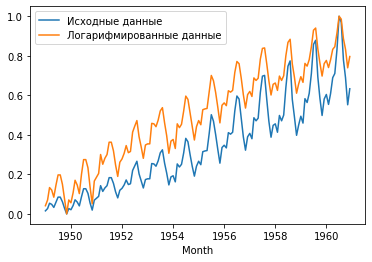

In [31]:
from sklearn.preprocessing import MinMaxScaler

sns.lineplot(
    x=airpassengers.Month,
    y=MinMaxScaler().fit_transform(airpassengers["#Passengers"].values.reshape(-1, 1)).flatten(),
    label="Исходные данные"
);

sns.lineplot(
    x=airpassengers.Month,
    y=MinMaxScaler().fit_transform(np.log(airpassengers["#Passengers"].values.reshape(-1, 1))).flatten(),
    label="Логарифмированные данные"
);

plt.legend(loc='best');

`fbprophet` имеет также полезные функции и для отладки.

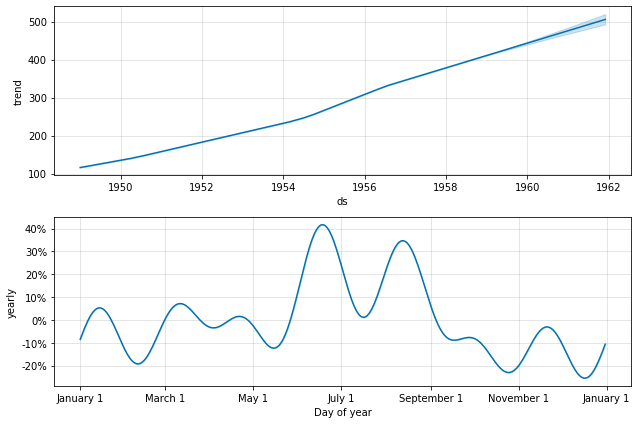

In [32]:
model.plot_components(forecast);

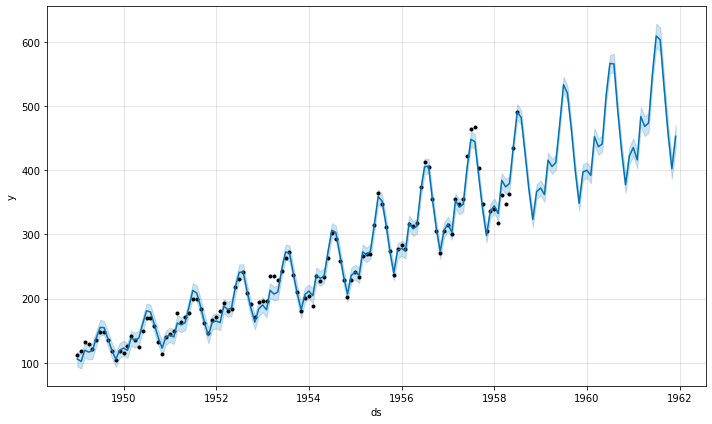

In [33]:
model.plot(forecast);

Вот так вот всё, можно спросить?


### Заключение

Нет. Это достаточно простой ряд. `fbprophet` имеет большое количество настроек сам по себе. Более того, для временных рядов следует отбирать модель немного другим механизмом кросс-валидации:
- сначала откладывается тренировочное множество,
- на нем тренируется модель, качество измеряется на отложенном хвосте,
- далее в тренировочное множество добавляются следующие точки (одна или несколько подряд),
- снова измеряется качество... 
- и так нужно делать столько раз, сколько у вас сочетаний параметров.

Сами по себе одномерные временные ряды редко встречаются в ~~дикой~~ природе. Тем не менее они полезны, когда у вас есть много временных признаков и вам хочется пустить их наперед для предсказания некоторой величины (например уровня инфляции от изменения ВВП и численности населения). В этом случае используется ***стэкинг***, и важно делать его правильно.


## 3.6 Стэкинг, или объединение нескольких моделей

Главное правило стэкинга - вы должны **обучать вторую модель на тех предсказаниях, которые были получены НЕ с тренировочного множества** первой модели. То есть (почти) как кросс-валидация - нельзя учить на тех же данных, про которые уже что-то известно.

Иначе вы получите "протечку" в данных, а на выходе - переобученную модель. Она будет очень много (очень) знать про своё тренировочное множество, но не будет хорошо генерализовать искомую зависимость в данных. То есть тренировочных множества должно быть как минимум два.

In [34]:
data = pd.read_csv('data/abalone.csv')

features = list(data.columns)
target = 'rings'
features.remove('sex')
features.remove(target)

from sklearn.model_selection import train_test_split

train_base_X, test_base_X, train_base_y, test_base_y = train_test_split(
    data[features].values, data[target].values.reshape(-1, 1),
    test_size=0.5, random_state=1
)

train_stack_X, test_stack_X, train_stack_y, test_stack_y = train_test_split(
    test_base_X, test_base_y,
    test_size=0.5, random_state=1
)

train_base_X.shape, train_stack_X.shape, test_stack_X.shape, \
train_base_y.shape, train_stack_y.shape, test_stack_y.shape,

((2088, 7), (1044, 7), (1045, 7), (2088, 1), (1044, 1), (1045, 1))

In [35]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor

base_estimator = MLPRegressor(random_state=1).fit(train_base_X, train_base_y)

stack_estimator = GradientBoostingRegressor(random_state=1).fit(
    np.column_stack([
        train_stack_X,
        base_estimator.predict(train_stack_X)
    ]),
    train_stack_y
)

"R2 stacked %.3f, R2 base %.3f" % (r2_score(
    test_stack_y,
    stack_estimator.predict(
        np.column_stack([
            test_stack_X,
            base_estimator.predict(test_stack_X)
        ])
    )
), r2_score(
    test_stack_y,
    base_estimator.predict(test_stack_X)
))

'R2 stacked 0.547, R2 base 0.513'

Как видим, в данном случае стэкинг улучшил результат. Но это бывает далеко не всегда так. И увлекаться им надо только с пониманием его цели. Мало того что неудобно бить датасет на многие части, так еще мы уменьшаем количество размеченных данных в случае стэкинга (а они у нас на вес золота).

К счастью в `sklearn` есть классы `StackingRegressor` и `StackingClassifier`, которые производят обучают последовательность моделей на всех данных, кроме последней модели, для которой они проводят уже обучение на разбиениях.

In [36]:
from sklearn.ensemble import StackingRegressor

regressor = StackingRegressor([
    ('MLP', MLPRegressor(random_state=1)),
    ('GBR', GradientBoostingRegressor(random_state=1))
]).fit(
    np.row_stack([
        train_base_X, train_stack_X
    ]),
    np.row_stack([
        train_base_y, train_stack_y
    ])
)

"R2 %.3f" % regressor.score(
    test_stack_X,
    test_stack_y
)

'R2 0.545'

С учетом кросс-валидации - практически то же самое.

Посмотрим, как можно использовать стэкинг для временных рядов. Для этого возьмем датасет *jena_climate* - датасет замера погодных характеристик около института (биогеохимии) Макса Планка в местечке *Jena* (Йена, Германия).

In [37]:
climate = pd.read_csv('data/jena_climate_2009_2016.csv', parse_dates=['Date Time'], dayfirst=True)
climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
Date Time          420551 non-null datetime64[ns]
p (mbar)           420551 non-null float64
T (degC)           420551 non-null float64
Tpot (K)           420551 non-null float64
Tdew (degC)        420551 non-null float64
rh (%)             420551 non-null float64
VPmax (mbar)       420551 non-null float64
VPact (mbar)       420551 non-null float64
VPdef (mbar)       420551 non-null float64
sh (g/kg)          420551 non-null float64
H2OC (mmol/mol)    420551 non-null float64
rho (g/m**3)       420551 non-null float64
wv (m/s)           420551 non-null float64
max. wv (m/s)      420551 non-null float64
wd (deg)           420551 non-null float64
dtypes: datetime64[ns](1), float64(14)
memory usage: 48.1 MB


Достаточно большой датасет. Мы выберем за целевую величину температуру в градусах, а за признаки - давление, влажность в процентах, скорость ветра в м/с и направление в градусах.

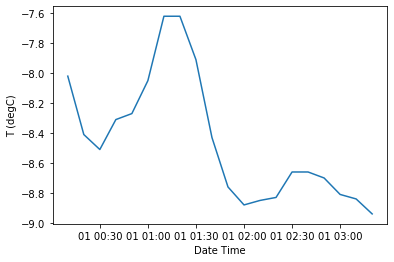

In [38]:
features = ['p (mbar)', 'rh (%)', 'wv (m/s)', 'wd (deg)', 'Date Time']
target = 'T (degC)'

sns.lineplot(x="Date Time", y=target, data=climate[:20]);

Нас не будут интересовать все 420 тысяч записей (каждые 10 минут), а только дневные, поэтому мы переиндексируем таблицу в среднедневные значения.

In [39]:
dataset = climate[features + [target]].set_index('Date Time').resample('D').mean()
dataset.describe()

,p (mbar),rh (%),wv (m/s),wd (deg),T (degC)
count,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000
mean,989.220852,76.031012,1.700779,174.772827,9.438993
std,8.095683,11.377820,23.155030,54.411625,7.840078
min,948.995972,37.580347,-1248.217847,0.000000,-16.457292
25%,984.359861,67.685764,1.448542,142.243611,3.808333
50%,989.530000,76.988472,1.903194,188.648264,9.708333
75%,994.432917,84.561319,2.586806,212.555000,15.444722
max,1013.957569,100.000000,7.644514,279.445139,29.375347


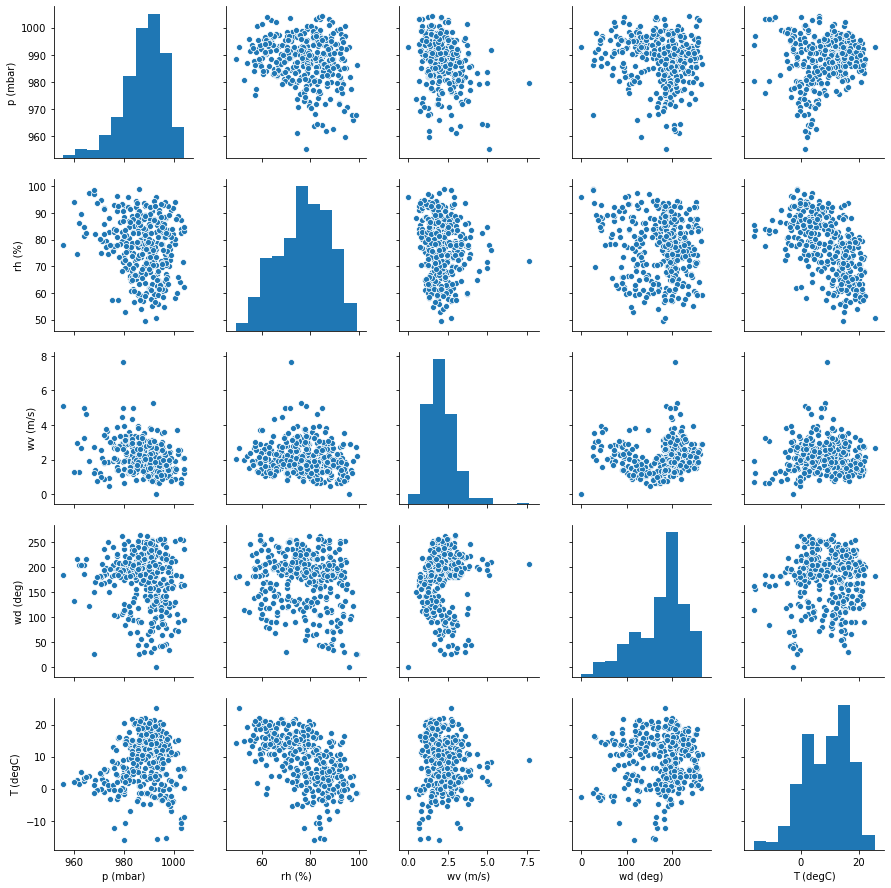

In [40]:
sns.pairplot(data=dataset[:365]);

Пока не очень верится, связаны ли признаки.

In [41]:
# удалим пропуски, вдруг они есть

data = dataset.dropna()

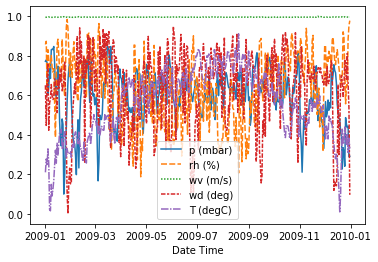

In [42]:
sns.lineplot(data=(data[:365] - data.min()) / (data.max() - data.min()));

Выглядит очень "рваненько". Разгладим значения *скользящим средним*. Скользящее среднее - это усреднее за некоторый период (окно), и в каждой точке для усреднения используются соседние значения (от текущей до минус размер окна пополам, до текущей плюс размер окна пополам).

Давайте сравним.

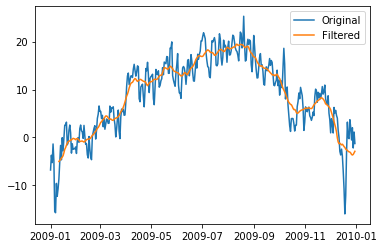

In [43]:
plt.plot(data['T (degC)'][:365], label='Original');
plt.plot(data['T (degC)'].rolling(window=20, center=True).mean()[:365], label='Filtered');
plt.legend(loc='best');

Мы потеряли некоторую информацию о погодных аномалиях, но в среднем не сильно большие отличия.

In [44]:
# применим ко всем данным и стандартизируем данные

data = data.rolling(window=20, center=True).mean().dropna()

mean = data.mean()
std = data.std()

data = (data - mean) / std

mean, std

(p (mbar)    989.146469
 rh (%)       75.981322
 wv (m/s)      1.701231
 wd (deg)    174.699809
 T (degC)      9.518540
 dtype: float64, p (mbar)     4.289267
 rh (%)       7.876976
 wv (m/s)     5.197971
 wd (deg)    23.847316
 T (degC)     7.043358
 dtype: float64)

In [45]:
def get_train_test_features(train_size, forecast_steps):
    result = {}
    features_without_date = list(data.columns)
    features_without_date.remove('T (degC)')    
    for feature in features_without_date:
        model = fbprophet.Prophet(
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=365 // 10
        ).fit(
            data[[feature]].reset_index().rename({
                'Date Time': 'ds',
                feature: 'y'
            }, axis='columns')[:train_size]
        )
        
        future = model.make_future_dataframe(
            forecast_steps, include_history=False
        )
        
        result[feature] = model.predict(future).yhat.values
    return result

features_train = 365 * 3 + 180
future_steps = len(data) - features_train + 365

features_forecast = get_train_test_features(
    train_size=features_train,
    forecast_steps=future_steps
)

In [46]:
features_data = pd.DataFrame(
    features_forecast,
    index=pd.date_range(start=data.index[features_train], periods=future_steps)
)

train = int(future_steps * 0.5)
test = len(data) - features_train - train

# поскольку у нас здесь обычная регрессия, мы можем примеры перемешать
X, y = shuffle(
    features_data[:train],
    data[target].values[features_train:features_train + train],
    random_state=1
)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer

target_regressor = make_pipeline(
    PolynomialFeatures(degree=2),
    PowerTransformer(),
    LinearRegression()
).fit(X, y)

"R2 test (%d samples) %.3f" % (test, target_regressor.score(
    features_data[train:train + test], data[target].values[
        features_train + train:features_train + train + test
    ]
))

'R2 test (631 samples) 0.733'

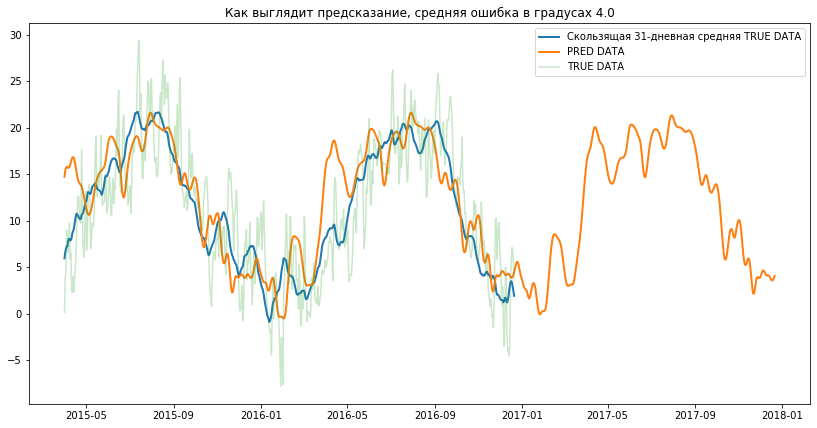

In [47]:
from sklearn.metrics import mean_absolute_error

t_original = dataset[target].dropna().values[
    features_train + train:features_train + train + test
]

t_predicted = target_regressor.predict(features_data[train:]) * std[target] + mean[target]

plt.figure(figsize=(14, 7))
plt.title('Как выглядит предсказание, средняя ошибка в градусах %.1f' % mean_absolute_error(
    t_original,
    t_predicted[:test]
));

plt.plot(
    features_data[train:train + test].index,
    data[target].values[
        features_train + train:features_train + train + test
    ] * std[target] + mean[target],
    label="Скользящая 31-дневная средняя TRUE DATA",
    lw=2
);
plt.plot(
    features_data[train:train + test + 365].index, 
    t_predicted[:test + 365],
    label='PRED DATA',
    lw=2
);
plt.plot(
    features_data[train:train + test].index,
    t_original,
    label='TRUE DATA',
    alpha=0.25
);
plt.legend(loc='best');

Как видим, со средней точностью до 4 градусов - температуру предсказывать можно хоть на пару лет вперёд :)

### Заключение

Правильный стэкинг - сложная вещь, и использовать его без крайней на то необходимости лишнее.